In [57]:
import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from mask_generator.transforms import KorniaInferTransform
from mask_generator.config import Config
import mask_generator.settings as settings
from mask_generator.models import create_model
from mask_generator.utils import load_config_from_yaml

In [58]:
CAR_PICTURE_DIR = "../Datasets/car_pictures/"

pictures = []

for root, dirs, files in os.walk(CAR_PICTURE_DIR):
    for file in files:
        if file.endswith(".png"):
            pictures.append(os.path.join(root, file))

print(len(pictures))

11133


In [59]:
RUN_DIR = "../experiments/20250626_200538_96718eef57/"

config = load_config_from_yaml(os.path.join(RUN_DIR, settings.config_filename))

In [60]:
image_path = random.choice(pictures)
print(f"Selected image: {image_path}")
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

Selected image: ../Datasets/car_pictures/320_180/frame_01716.png


In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model, pad_divisor = create_model(config.model)
model.load_state_dict(torch.load(os.path.join(RUN_DIR, settings.model_filename), map_location=device))
model.eval()
model.to(device)

Using device: cuda


MyUNet(
  (encoders): ModuleList(
    (0): EncoderBlock(
      (conv): ConvBlock(
        (block): Sequential(
          (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu_1): ReLU()
          (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu_2): ReLU()
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): EncoderBlock(
      (conv): ConvBlock(
        (block): Sequential(
          (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu_1): ReLU()
          (conv_2): Conv2d(64, 

In [62]:
transform = KorniaInferTransform(
    image_size=config.training.image_size,
    pad_divisor=pad_divisor,
    device=device,
)

preprocessed_image = transform(image=original_image)

with torch.no_grad():
    picture_tensor = preprocessed_image.unsqueeze(0).to(device)
    outputs = model(picture_tensor)
    outputs = torch.sigmoid(outputs)
    outputs = (outputs > 0.5).float()

Mask is None, falling back to road_optimized crop.


Input image shape: (128, 384, 3)


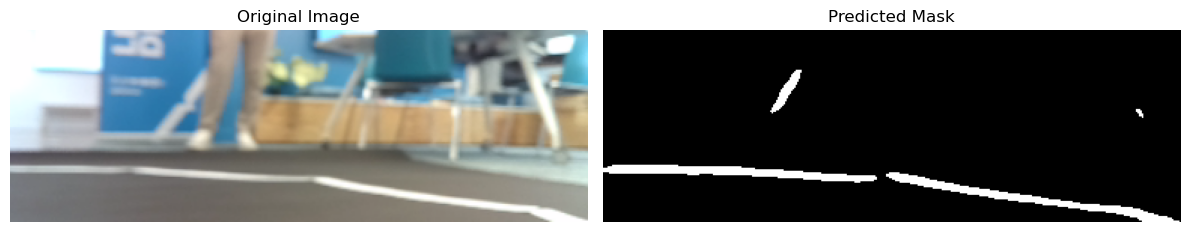

In [63]:
input_image_np = transform.to_image(preprocessed_image)
print(f"Input image shape: {input_image_np.shape}")
mask_np = transform.to_mask(outputs)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(input_image_np)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(mask_np, cmap="gray")
axes[1].set_title("Predicted Mask")
axes[1].axis("off")

plt.tight_layout()
plt.show()